In [3]:
ENV["JULIA_CUDA_HARD_MEMORY_LIMIT"]="20GiB"

"20GiB"

In [4]:
# import Makie
# import CairoMakie
import MLDatasets
using Statistics: mean, std, var
using Random: bitrand
using ValueHistories: MVHistory, @trace
using RestrictedBoltzmannMachines: BinaryRBM, sample_from_inputs,
    initialize!, log_pseudolikelihood, pcd!, free_energy, sample_v_from_v
using Plots

using CudaRBMs: cpu, gpu
using CUDA

In [5]:
imggrid(A::AbstractArray{<:Any,4}) =
    reshape(permutedims(A, (1,3,2,4)), size(A,1)*size(A,3), size(A,2)*size(A,4))

imggrid (generic function with 1 method)

In [6]:
include("utils/loader.jl")
include("utils/structs.jl")

In [7]:
Random.seed!(1234);
hparams = HyperParams(nv=28*28, nh=400, batch_size=256, gpu_usage=true)

HyperParams
  nv: Int64 784
  nh: Int64 400
  batch_size: Int64 256
  lr: Float64 0.0002
  γ: Float64 0.001
  t: Int64 10
  gpu_usage: Bool true
  optType: String "SGD"


In [8]:
x = loadData(; hparams, dsName="MNIST01", numbers = [0,1,2,3,4,5,6,7,8,9], normalize=false, testset=false)
train_x = CuArray(reshape(hcat(x...),28,28,:));

[ Info: 60000


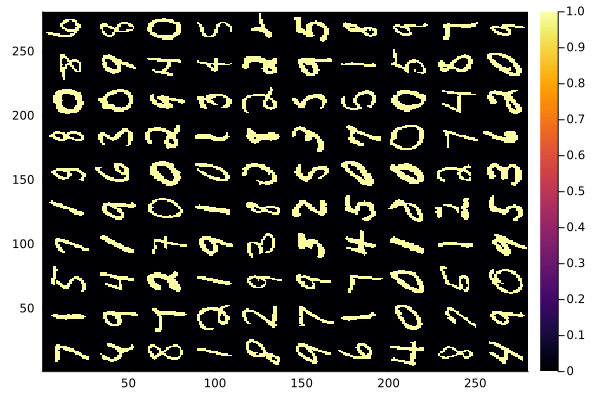

In [12]:
lnum = 10
samp = train_x[:,:,1:100] |> cpu;
heatmap(cat([cat([samp[:,:,i+j*lnum] for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

In [87]:
# train_x

In [14]:
rbm = gpu(BinaryRBM(Float32, (28,28), 500))
initialize!(rbm, train_x)

RestrictedBoltzmannMachines.RBM{RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}(RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}([-13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; … ;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551]), RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}(Float32[0.0 0.0 … 0.0 0.0]), [-0.0022538195 0.005812872 … 0.016610162 -0.0027991585; -0.014043135 9.742228f-5 … -0.006133136 0.00579788; … ; 0.010064065 0.017372543 … -0.014884407 0.005979353; 0.001249184 -0.01750939 … -0.009241138 -0.001795095;;; -0.0009806225 0.00034140758 … -0.012662658 -0.014073438; 0.013692501 

In [15]:
println("log(PL) = ", mean(@time log_pseudolikelihood(rbm, train_x)))

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007f5285ce7850.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/uOYfN/src/GPUArraysCore.jl:106


  5.459092 seconds (6.99 M allocations: 518.572 MiB, 2.94% gc time)
log(PL) = -0.2649144


In [16]:
batchsize = 500 #256
iters = 10000
history = MVHistory()
@time pcd!(
    rbm, train_x; steps=100, iters, batchsize,
    callback = function(; iter, _...)
        if iszero(iter % 100)
            lpl = mean(log_pseudolikelihood(rbm, train_x))
            @trace history iter lpl
        end
    end
)


615.841192 seconds (374.30 M allocations: 19.995 GiB, 30.02% gc time, 0.03% compilation time: 22% of which was recompilation)


((visible = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; … ;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45], [8.74528f-13 1.61457f-11 … 2.48924f-11 1.45969f-9;;; 2.62197f-13 2.24308f-13 … 1.5232f-9 1.31407f-12;;; 9.14378f-12 7.67515f-12 … 8.89119f-11 9.29563f-13;;; … ;;; 6.2402f-12 4.93936f-13 … 2.16299f-12 3.70111f-12;;; 1.61282f-9 2.86644f-11 … 2.40822f-13 7.94868f-12;;; 3.20921f-13 2.71813f-13 … 5.12089f-11 5.10044f-11], (6.0f-45, 4.5134f-5))), hidden = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[0.0100642 0.058196 … -0.0273504 0.0453746], Float32[0.00665554 0.0201165 … 0.0110158 0.0130278], (6.0f-45, 4.5134f-5))), w = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([6.0f-45 6.0f-45 … 6.0f-45 6.0f-45; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45; … ; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45; 6.0

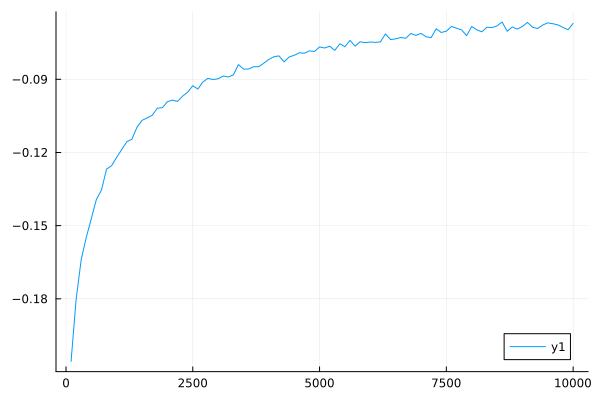

In [17]:
plot(get(history, :lpl))

In [19]:
nrows, ncols = 10, 15
nsteps = 3000
fantasy_F = gpu(zeros(nrows*ncols, nsteps))
fantasy_x = gpu(bitrand(28,28,nrows*ncols))
fantasy_F[:,1] .= free_energy(rbm, fantasy_x)
@time for t in 2:nsteps
    fantasy_x .= sample_v_from_v(rbm, fantasy_x)
    fantasy_F[:,t] .= free_energy(rbm, fantasy_x)
end


  0.995061 seconds (1.53 M allocations: 61.977 MiB)


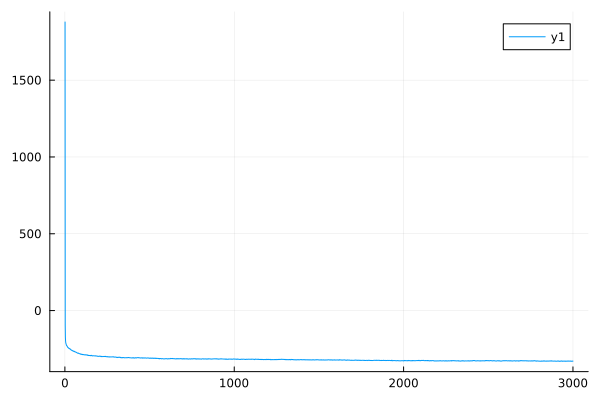

In [20]:
fantasy_F_μ = vec(mean(fantasy_F; dims=1))
fantasy_F_σ = vec(std(fantasy_F; dims=1))

# plot(1:nsteps, fantasy_F_μ - fantasy_F_σ/2, fantasy_F_μ + fantasy_F_σ/2)
plot(1:nsteps, fantasy_F_μ)

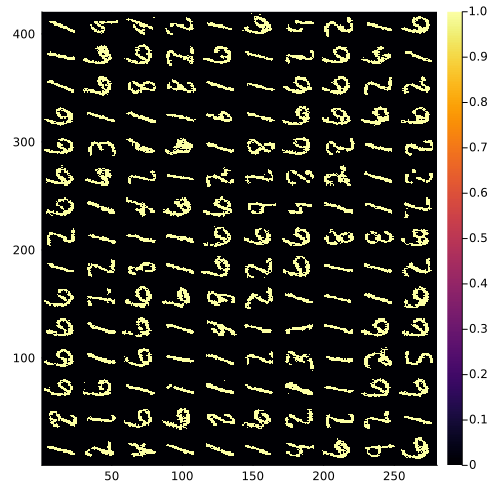

In [21]:


heatmap(cpu(imggrid(reshape(fantasy_x, 28, 28, ncols, nrows))), size=(500,500))

In [22]:
include("utils/train.jl")

In [23]:
rbmJ, J, m, hparams, rbmZJ = initModel(nv=28*28, nh=500, batch_size=500, lr=1.5, t=10, gpu_usage = true, optType="Adam")
opt = initOptW(hparams, J);

In [24]:
x, y = loadData(; hparams, dsName="MNIST01", numbers=collect(0:9), testset=true);
TS = Test(x,y)
lnum=10

[ Info: 10000


10

In [34]:
# J.w
# reshape(rbm.w,28*28,500)
dev = gpu

gpu (generic function with 13 methods)

In [43]:
J.b = rbm.hidden.θ
J.a = reshape(rbm.visible.θ,28*28)
J.w = reshape(rbm.w,28*28,500);

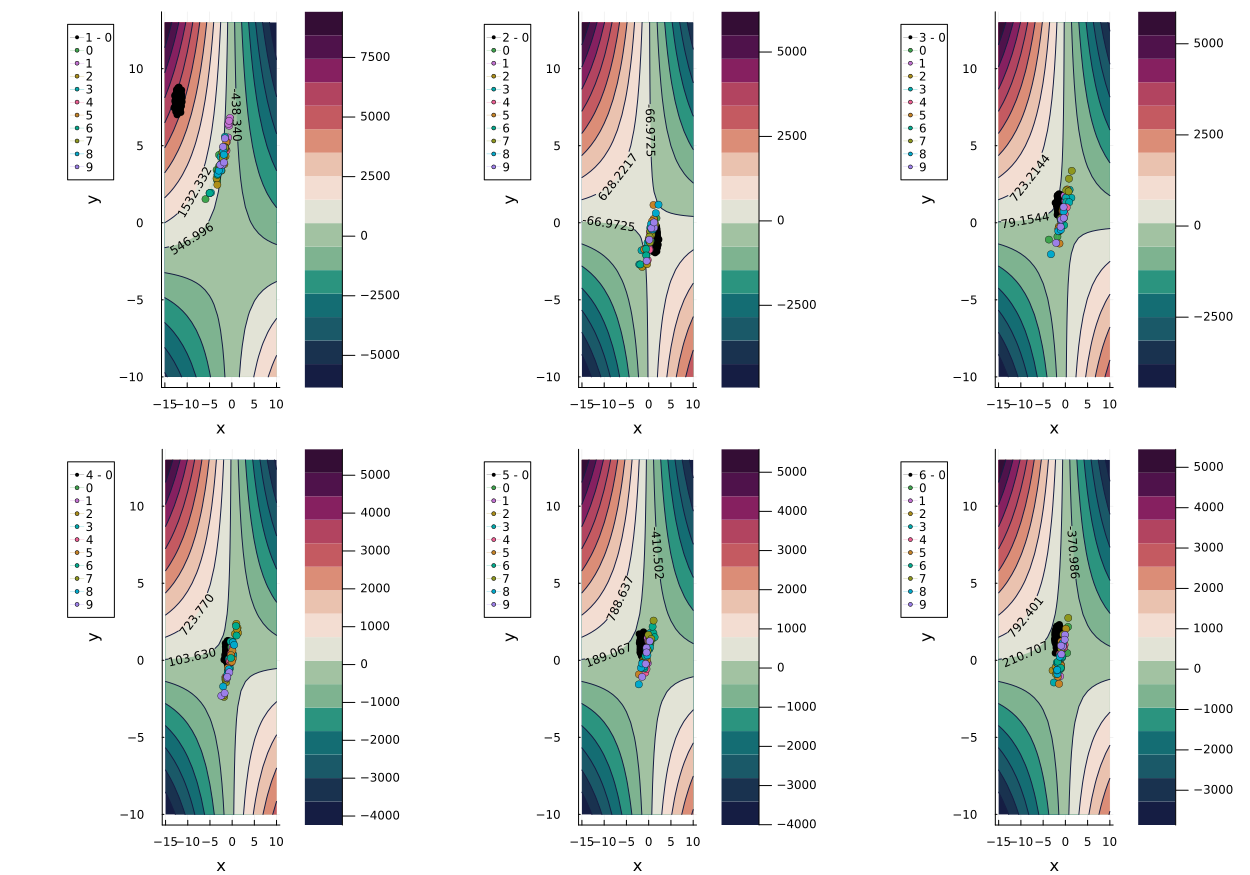

In [45]:
plotLandscapes(rbmJ, J, lnum ; τ=0, kmax=6, TS, dev, hparams)

###############

In [29]:
# import Makie
# import CairoMakie
import MLDatasets
using Statistics: mean, std, var
using Random: bitrand
using ValueHistories: MVHistory, @trace
using RestrictedBoltzmannMachines: BinaryRBM, sample_from_inputs,
    initialize!, log_pseudolikelihood, pcd!, free_energy, sample_v_from_v
using Plots

using CudaRBMs: cpu, gpu
using CUDA

In [48]:
imggrid(A::AbstractArray{<:Any,4}) =
    reshape(permutedims(A, (1,3,2,4)), size(A,1)*size(A,3), size(A,2)*size(A,4))

imggrid (generic function with 1 method)

In [30]:
Float = Float32
train_x = MLDatasets.MNIST(split=:train)[:].features
train_y = MLDatasets.MNIST(split=:train)[:].targets
# train_x = Array{Float}(train_x[:, :, train_y .== 0] .≥ 0.5);
train_x = CuArray{Float}(train_x[:, :, train_y .== 0] .≥ 0.5);

In [43]:
nrows, ncols = 10, 15
lnum = 10
samp = train_x[:,:,1:100] |> cpu;

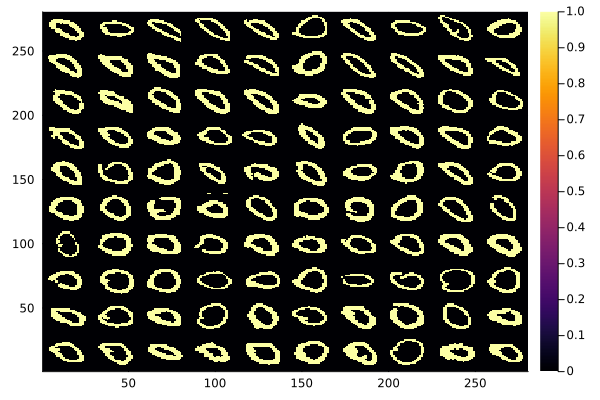

In [32]:
heatmap(cat([cat([samp[:,:,i+j*lnum] for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

In [33]:
# rbm = BinaryRBM(Float, (28,28), 400)
rbm = gpu(BinaryRBM(Float, (28,28), 400))
initialize!(rbm, train_x) # match single-site statistics


RestrictedBoltzmannMachines.RBM{RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}, RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}(RestrictedBoltzmannMachines.Binary{2, CuArray{Float32, 3, CUDA.Mem.DeviceBuffer}}([-13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; … ;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551;;; -13.81551 -13.81551 … -13.81551 -13.81551]), RestrictedBoltzmannMachines.Binary{1, CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}}(Float32[0.0 0.0 … 0.0 0.0]), [-0.0070385453 -0.01879656 … 0.005937164 0.0023454519; 0.008564193 -0.00035005086 … 0.009737052 -0.0015637086; … ; 0.0025739742 0.016190372 … 0.003714579 -0.010958271; -0.0038490738 0.014161518 … 0.0026757235 0.00043587195;;; -0.0027011693 0.0023952646 … 0.008711701 -0.002356749; 0.00011

In [34]:
println("log(PL) = ", mean(@time log_pseudolikelihood(rbm, train_x)))

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fcaa34e36c0.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/uOYfN/src/GPUArraysCore.jl:106


  4.200990 seconds (5.60 M allocations: 394.641 MiB, 3.51% gc time)
log(PL) = -0.25752798


In [35]:
batchsize = 256
iters = 10000
history = MVHistory()
@time pcd!(
    rbm, train_x; iters, batchsize,
    callback = function(; iter, _...)
        if iszero(iter % 100)
            lpl = mean(log_pseudolikelihood(rbm, train_x))
            @trace history iter lpl
        end
    end
)


 40.067525 seconds (45.92 M allocations: 3.151 GiB, 3.03% gc time, 0.18% compilation time)


((visible = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([6.0f-45 6.0f-45 … 6.0f-45 6.0f-45;;; 6.0f-45 0.0 … 0.0 6.0f-45;;; 0.0 6.0f-45 … 6.0f-45 6.0f-45;;; … ;;; 6.64849f-38 6.0f-45 … 6.0f-45 6.0f-45;;; 9.19575f-10 6.0f-45 … 6.0f-45 3.06842f-6;;; 6.0f-45 6.0f-45 … 6.0f-45 6.0f-45], [1.05416f-9 3.4483f-10 … 1.26197f-9 1.02254f-10;;; 1.14036f-10 0.0 … 0.0 4.28871f-10;;; 0.0 4.36026f-9 … 5.4063f-11 3.88776f-10;;; … ;;; 7.42321f-9 1.68951f-9 … 6.1086f-11 3.32273f-12;;; 1.34918f-8 1.10997f-10 … 8.35367f-13 1.47032f-8;;; 1.08247f-12 1.6926f-11 … 2.78507f-12 6.46661f-11], (6.0f-45, 4.5134f-5))), hidden = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), (Float32[0.018771 -0.0141754 … -0.00606035 -0.00745173], Float32[0.0188829 0.00127452 … 0.00223204 0.00101674], (6.0f-45, 4.5134f-5))), w = Leaf(Adam{Float32}(0.001, (0.9, 0.999), 1.19209f-7), ([6.0f-45 6.0f-45 … 8.69161f-12 6.0f-45; 6.0f-45 0.0 … 6.0f-45 6.0f-45; … ; 6.0f-45 0.0 … 6.0f-45 6.0f-45; 6.0f-45 6.0f-45 … 2.03256f-20 6.

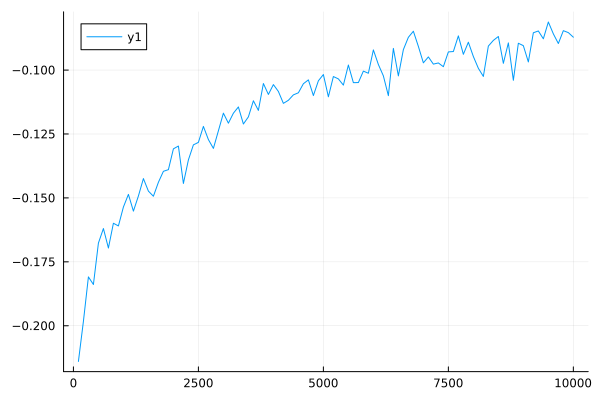

In [40]:
plot(get(history, :lpl))

In [45]:
nsteps = 3000
fantasy_F = gpu(zeros(nrows*ncols, nsteps))
fantasy_x = gpu(bitrand(28,28,nrows*ncols))
fantasy_F[:,1] .= free_energy(rbm, fantasy_x)
@time for t in 2:nsteps
    fantasy_x .= sample_v_from_v(rbm, fantasy_x)
    fantasy_F[:,t] .= free_energy(rbm, fantasy_x)
end


  0.975290 seconds (1.48 M allocations: 60.398 MiB)


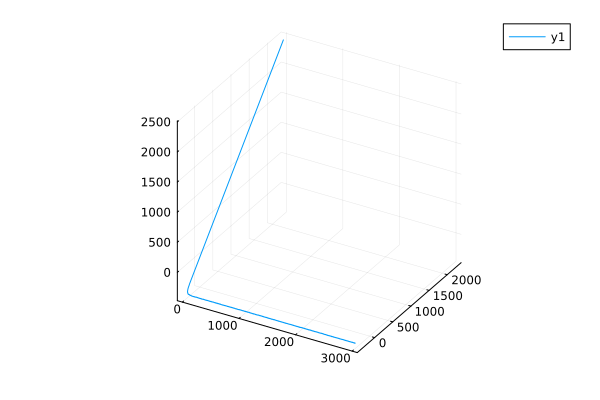

In [46]:
fantasy_F_μ = vec(mean(fantasy_F; dims=1))
fantasy_F_σ = vec(std(fantasy_F; dims=1))
# Makie.band!(ax, 1:nsteps, fantasy_F_μ - fantasy_F_σ/2, fantasy_F_μ + fantasy_F_σ/2)
# Makie.lines!(ax, 1:nsteps, fantasy_F_μ)
plot(1:nsteps, fantasy_F_μ - fantasy_F_σ/2, fantasy_F_μ + fantasy_F_σ/2)

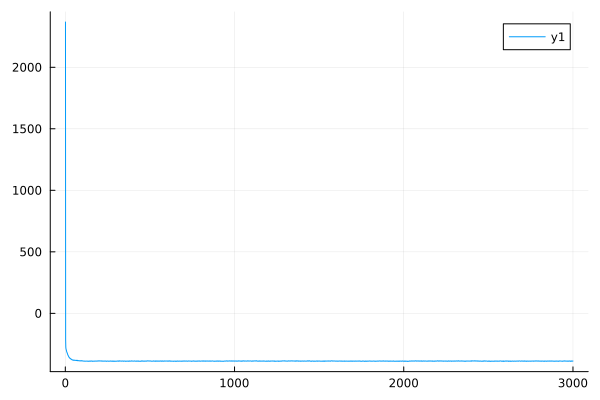

In [47]:
plot(1:nsteps, fantasy_F_μ)

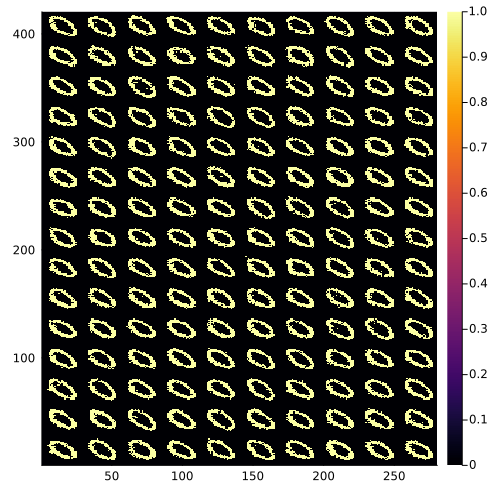

In [53]:
heatmap(cpu(imggrid(reshape(fantasy_x, 28, 28, ncols, nrows))), size=(500,500))